In [1]:
from transformers import BertTokenizer, BertModel
import torch

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# will be 11 Tokens for Bert
sentence = "Sphinx of black quartz, judge my vow."

In [11]:
# Add the special tokens.
marked_text = f"[CLS] {sentence} [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

segments_ids = [1 for _ in range(len(tokenized_text))]

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[-1]


# `hidden_states` has shape [13 x 1 x 11 x 768]
# `token_vecs` is a tensor with shape [11 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [14]:
token_vecs.shape

torch.Size([11, 768])

In [37]:
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')
corpus = """So she was considering in her own mind (as well as she could,
            for the hot day made her feel very sleepy and stupid), whether
            the pleasure of making a daisy-chain would be worth the trouble
            of getting up and picking the daisies, when suddenly a White
            Rabbit with pink eyes ran close by her.""".split()

result = pd.DataFrame()

for i in range(3, len(corpus)):

    corpus_embeddings = embedder.encode(corpus[:i], convert_to_tensor=True)
    three_dim = PCA(n_components=3, random_state=0).fit_transform(corpus_embeddings)

    df = pd.DataFrame(data=[x for x in three_dim], columns=["x", "y", "z"])
    df["label"] = corpus[:i]
    df["frame"] = i
    result = pd.concat([result, df])

# normalize
result["x"] = (result["x"] - result["x"].min()) / (result["x"].max() - result["x"].min())
result["y"] = (result["y"] - result["y"].min()) / (result["y"].max() - result["y"].min())
result["z"] = (result["z"] - result["z"].min()) / (result["z"].max() - result["z"].min())

In [40]:
from PIL import Image

for i in range(3, len(corpus)):
    sample = result[result["frame"] == i][["x", "y", "z"]]
    c = sample.iloc[-1].values * 255
    img = Image.new('RGB', (300, 300), (int(c[0]), int(c[1]), int(c[2])))
    img.save(f"img/alice{i:03}.jpg")

In [54]:
import os
import imageio.v2 as imageio
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

img_dir = "img/"
fnt = ImageFont.truetype("FreeMono.ttf", 25)
images = []
for i in range(3, len(corpus)):
    file_path = os.path.join(img_dir, f"alice{i:03}.jpg")
    for _ in range(5):
        img = Image.open(file_path)
        ctx = ImageDraw.Draw(img)
        ctx.text((100, 100), corpus[i], fill=(255, 255, 255), font=fnt, stroke_width=1)
        images.append(img)

imageio.mimsave("colors_alice.gif", images)

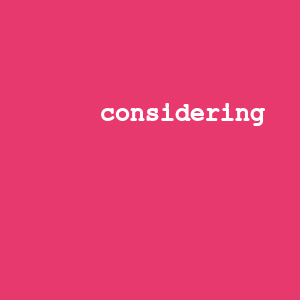

In [55]:
from IPython.display import Image
Image(filename="colors_alice.gif")

In [ ]:
# TODO: Try out KernelPCA and TSNE from sklearn
# try out feeding in a sliding window over the text
# what length is the best? Make it to short and the change isn't smooth anymore
# make it to large and there is no change?
# coming up next!